<a href="https://colab.research.google.com/github/Ifeeding99/tensorflow-scripts/blob/main/tfrecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving chest_zip.zip to chest_zip.zip


In [ ]:
import zipfile
f = zipfile.ZipFile('chest_zip.zip')
f.extractall()

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory('/content/chest_ct_scan_extracted - Copy/Data/train',
                                             label_mode = 'int',
                                             image_size = (256,256))

Found 613 files belonging to 4 classes.


In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.train import Example, Features, Feature, BytesList, FloatList, Int64List
from tensorflow.io import TFRecordWriter

In [ ]:
import os
os.listdir('/content/chest_ct_scan_extracted - Copy/Data/train')

['large_cell_carcinoma', 'adenocarcinoma', 'normal', 'squamous_cell_carcinoma']

In [ ]:
labels = {
    'adenocarcinoma':0,
    'large_cell_carcinoma':1,
    'normal':2,
    'squamous_cell_carcinoma':3
}

In [ ]:
train_path = '/content/chest_ct_scan_extracted - Copy/Data/train'

with TFRecordWriter('train_encoded.tfrecords') as f:
  for folder in os.listdir(train_path):
    for el in os.listdir(os.path.join(train_path,folder)):
      folder_path = os.path.join(train_path,folder)
      path = os.path.join(folder_path,el)
      label = labels[folder]
      img = tf.io.decode_png(tf.io.read_file(path))

      features = {
          'image':Feature(bytes_list=BytesList(value=[tf.io.encode_png(img).numpy()])),
          'label':Feature(int64_list=Int64List(value=[label]))
      }

      ex = Example(features=Features(feature = features))
      f.write(ex.SerializeToString())


In [ ]:
def decode_record(record):
  features = {
      'image':tf.io.FixedLenFeature([], dtype=tf.string),
      'label':tf.io.FixedLenFeature([], dtype=tf.int64)
  }
  ex = tf.io.parse_single_example(record, features)
  ex['image'] = tf.io.decode_png(ex['image'], channels = 1) # default channels is 0
  return ex['image'],ex['label'] # return only the things you need, not the whole example object

dataset_record = tf.data.TFRecordDataset('train_encoded.tfrecords')
dataset_record = dataset_record.map(decode_record)

In [ ]:
dataset_record.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
import matplotlib.pyplot as plt

tf.Tensor(1, shape=(), dtype=int64)


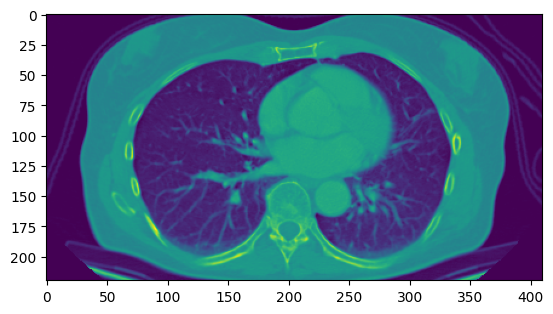

In [ ]:
for X,y in dataset_record.take(1):
  plt.imshow(X)
  print(y)

In [ ]:
# now doing it for validation and test too

validation_path = '/content/chest_ct_scan_extracted - Copy/Data/valid'

with TFRecordWriter('validation_encoded.tfrecords') as f:
  for folder in os.listdir(validation_path):
    path = os.path.join(validation_path,folder)
    for el in os.listdir(path):
      label = labels[folder]
      img = tf.io.decode_png(tf.io.read_file(os.path.join(path,el)))

      feature = {
          'image':Feature(bytes_list=BytesList(value=[tf.io.encode_png(img).numpy()])),
          'label':Feature(int64_list=Int64List(value=[label]))
      }

      ex = Example(features=Features(feature=feature))
      f.write(ex.SerializeToString())

In [ ]:
# deconding validation file, I will rewrite the functions to practice
def decode_val(record):
  feature = {
      'image':tf.io.FixedLenFeature([], tf.string),
      'label':tf.io.FixedLenFeature([], tf.int64)
  }
  ex = tf.io.parse_single_example(record, feature)
  ex['image'] = tf.io.decode_png(ex['image'], channels = 1)
  return ex['image'],ex['label']

val_dataset_decode = tf.data.TFRecordDataset('/content/validation_encoded.tfrecords')
val_dataset_decode = val_dataset_decode.map(decode_val)
val_dataset_decode.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

tf.Tensor(1, shape=(), dtype=int64)


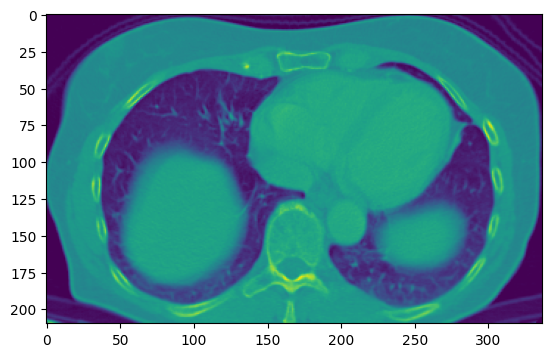

In [ ]:
val_dataset_decode = val_dataset_decode.shuffle(buffer_size=1000)
for X,y in val_dataset_decode.take(1):
  plt.imshow(X)
  print(y)

In [ ]:
# now for the test folder

test_path = '/content/chest_ct_scan_extracted - Copy/Data/test'

with TFRecordWriter('test_encoded.tfrecords') as f:
  for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path,folder)
    for el in os.listdir(folder_path):
      img_path = os.path.join(folder_path,el)
      img = tf.io.decode_png(tf.io.read_file(img_path))
      label = labels[folder]

      feature = {
          'image':Feature(bytes_list=BytesList(value=[tf.io.encode_png(img).numpy()])),
          'label':Feature(int64_list=Int64List(value=[label]))
      }

      ex = Example(features = Features(feature=feature))
      f.write(ex.SerializeToString())


In [ ]:
def decode_test(record):
  feature = {
      'image':tf.io.FixedLenFeature([], tf.string),
      'label':tf.io.FixedLenFeature([],tf.int64)
  }
  ex = tf.io.parse_single_example(record,feature)
  ex['image'] = tf.io.decode_png(ex['image'], channels = 1)
  return ex['image'],ex['label']

test_dataset_decoded = tf.data.TFRecordDataset('/content/test_encoded.tfrecords')
test_dataset_decoded = test_dataset_decoded.map(decode_test)
test_dataset_decoded.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

tf.Tensor(0, shape=(), dtype=int64)


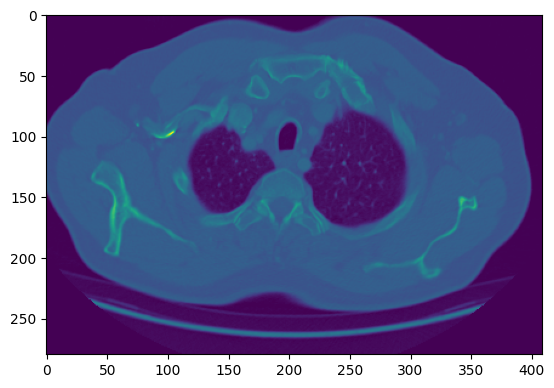

In [ ]:
test_dataset_decoded = test_dataset_decoded.shuffle(buffer_size=1000)
for X,y in test_dataset_decoded.take(1):
  plt.imshow(X)
  print(y)

In [ ]:
import keras_tuner as kt

In [ ]:
from tensorflow.keras.layers import Dense, Rescaling, Activation, Normalization, Flatten, Resizing, Reshape

In [ ]:
train = dataset_record.map(lambda x,y: (Resizing(256,256)(x), y)).shuffle(buffer_size=1000).batch(256)
val = val_dataset_decode.map(lambda x,y: (Resizing(256,256)(x), y)).shuffle(buffer_size=1000).batch(256)
test = test_dataset_decoded.map(lambda x,y: (Resizing(256,256)(x), y)).shuffle(buffer_size=1000).batch(256)

In [ ]:
for x,y in train.take(1):
  flat = Flatten(input_shape=(None,256,256))
  print(flat(x))

tf.Tensor(
[[0.0000000e+00 4.1601562e-01 3.0664062e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.5000000e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.5400000e+02 2.5400000e+02 2.5400000e+02 ... 2.5400000e+02
  2.5400000e+02 2.5400000e+02]], shape=(256, 65536), dtype=float32)


In [ ]:
(X_train, y_train),(X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X = train.map(lambda x,y: x)
norm = Normalization()
norm.adapt(X)

In [ ]:
def build_model(hp):
  n_hidden_layers = hp.Int('n_hidden_layers', min_value = 1, max_value = 10)
  n_neurons = hp.Int('n_neurons_per_layer',min_value = 10, max_value = 20)
  activation = hp.Choice('activation',['relu','selu','gelu','swish'])
  optimizer = hp.Choice('optimizer',['adam','nag'])
  normalization = hp.Choice('normalization', [True, False])

  input_ = tf.keras.Input(shape=(256,256))
  x = Flatten()(input_)
  if normalization:
    x = norm(x)
  else:
    x=Rescaling(1/255)(x)
  for _ in range(n_hidden_layers):
    x=Dense(units = n_neurons)(x)
    x=Activation(activation)(x)

  x= Dense(units = 4, activation = tf.nn.softmax)(x)
  model = tf.keras.Model(inputs=input_, outputs=x)

  if optimizer == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate = 1e-3)
  else:
    optim = tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9, nesterov = True)

  model.compile(optimizer = optim,
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                metrics = ['accuracy'])

  return model

tuner = kt.BayesianOptimization(build_model, objective = 'val_accuracy', max_trials = 50, seed = 42)
tuner.search(train,
             validation_data = val,
             epochs = 10)

Trial 50 Complete [00h 00m 59s]
val_accuracy: 0.4583333432674408

Best val_accuracy So Far: 0.6666666865348816
Total elapsed time: 00h 30m 25s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'n_hidden_layers': 4,
 'n_neurons_per_layer': 14,
 'activation': 'relu',
 'optimizer': 'nag',
 'normalization': 1}

In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)
best_trial[0].summary()

Trial 26 summary
Hyperparameters:
n_hidden_layers: 4
n_neurons_per_layer: 14
activation: relu
optimizer: nag
normalization: 1
Score: 0.6666666865348816
